# Perfect-model predictability Module Demo

Aaron Spring and Riley Brady

---

This demo demonstrates the capabilities of the prediction module for a perfect-model framework ensemble simulation.

# What's a perfect-model framework simulation?

Technically:
- a set of ensemble simulations based on an Earth-System-Model alone
- no assimilation of any reanalysis or data product interfers with the model
- any number of `members` are initialized from perturbed initial conditions is called `ensemble` (often the ensemble initialized in `1955`)
- the control simulation can be viewed as just another member

How to compare predictability skill score:
- As no observational data interfers with the random climate evolution of the model, we cannot use a observation-based reference.
- Therefore we can compare the members with each other (`m2m`) or against the ensemble mean (`m2e`) or the control (`m2c`) or the ensemble mean against the control (`e2c`).

When to use:
- you don't have a sufficiently long of observational records to use as a `reference`
- you want to aviod biases between model climatology and reanalysis climatology
- you want to aviod super sensitive reactions of biogeochemical cycles to disruptive changes in ocean physics due to assimilation
- you want to delve into process understanding of predictability of a model without outside artefacts

How does it look like?
[See 4.2](#timeseries)

---

Some papers including perfect-model simulations:
- Griffies, S. M., and K. Bryan. “A Predictability Study of Simulated North Atlantic Multidecadal Variability.” Climate Dynamics 13, no. 7–8 (August 1, 1997): 459–87. https://doi.org/10/ch4kc4.
- Collins, Matthew, and Sinha Bablu. “Predictability of Decadal Variations in the Thermohaline Circulation and Climate.” Geophysical Research Letters 30, no. 6 (March 22, 2003). https://doi.org/10/cts3cr.
- Pohlmann, Holger, Michael Botzet, Mojib Latif, Andreas Roesch, Martin Wild, and Peter Tschuck. “Estimating the Decadal Predictability of a Coupled AOGCM.” Journal of Climate 17, no. 22 (November 1, 2004): 4463–72. https://doi.org/10/d2qf62.
- Hawkins, Ed, Steffen Tietsche, Jonathan J. Day, Nathanael Melia, Keith Haines, and Sarah Keeley. “Aspects of Designing and Evaluating Seasonal-to-Interannual Arctic Sea-Ice Prediction Systems.” Quarterly Journal of the Royal Meteorological Society 142, no. 695 (January 1, 2016): 672–83. https://doi.org/10/gfb3pn.
- Bushuk, Mitchell, Rym Msadek, Michael Winton, Gabriel Vecchi, Xiaosong Yang, Anthony Rosati, and Rich Gudgel. “Regional Arctic Sea–Ice Prediction: Potential versus Operational Seasonal Forecast Skill.” Climate Dynamics, June 9, 2018. https://doi.org/10/gd7hfq.
- Séférian, Roland, Sarah Berthet, and Matthieu Chevallier. “Assessing the Decadal Predictability of Land and Ocean Carbon Uptake.” Geophysical Research Letters, March 15, 2018. https://doi.org/10/gdb424. 

---
**This demo:**

Input:
- 1-dimensional xr.Dataset timeseries output
- 3-dimensional xr.DataArray maps output

Shows:
- skill score
- predictability horizon
- slow components of internal variability indicating potential predictability:
 - DPP
 - variance-weighted mean period
 - decorrelation time
---

In [2]:
import xarray as xr
import numpy as np
import climpred as cp
import matplotlib.pyplot as plt
from climpred.prediction import (compute_perfect_model, bootstrap_perfect_model, 
                                 xr_predictability_horizon, DPP, compute_persistence)
from climpred.loadutils import get_datasets, open_dataset

from climpred.stats import (xr_decorrelation_time, xr_varweighted_mean_period, 
                           xr_autocorr)
%matplotlib inline

# How to analyze a perfect-model framework simulation?

In [2]:
print(cp.prediction.__doc__)


Objects dealing with decadal prediction metrics.

Concept of calculating predictability skill
-------------------------------------------
- metric: how is skill calculated, e.g. pearson_r, rmse
- comparison: how forecasts and observation/truth are compared, e.g., m2m, e2r

High-level functions
-------------------
- compute_perfect_model: computes the perfect-model predictability skill
according to metric and comparison
- compute_reference: computes predictability/skill relative to some reference
- compute_persistence: computes a persistence forecast from some simulation
- bootstrap from uninitialized ensemble:
    - PM_sig(ds, control, metric=rmse, comparison=_m2m, bootstrap=500, sig=99)
    - threshold to determine predictability horizon

# TODO: make metrics non-dependent of prediction framework used
Metrics (submit to functions as strings)
-------
- mse: Mean Square Error (perfect-model only)
- nev: Normalized Ensemble Variance (perfect-model only)
- msss: Mean Square Skill Score (

# Load sample data
Subset of ensembles and members from MPI-ESM-LR (CMIP6 version) esmControl simulation of an early state. vga0214 from year 3000 to 3300.

## 1-dimensional output

1-d output contains datasets of timeseries of a certain averaging **area**s ('global, North_Atlantic') and averaging time **period** (ym, DJF, ...) for some lead **year**s (1..20).
- ds: the ensemble dataset of all **member**s (1..10), **ensemble**s (initialization years: here 3014, 3023, ...), areas, periods and years
- control: the control dataset of all areas, periods and years

In [3]:
ds = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_ds.nc')
control = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_control.nc')

In [4]:
get_datasets()

'MPI-DP-1D': decadal prediction ensemble area averages of SST/SSS/AMO.
'MPI-DP-3D': decadal prediction ensemble lat/lon/time of SST/SSS/AMO.
'MPI-control-1D': area averages for the control run of SST/SSS.
'MPI-control-3D': lat/lon/time for the control run of SST/SSS.
'CESM-DP': decadal prediction ensemble of global mean SSTs.
'CESM-LE': uninitialized ensemble of global mean SSTs.
'ERSST': observations of global mean SSTs.
'CESM-reference': hindcast simulation that initializes CESM-DP.


In [5]:
ds = open_dataset('MPI-DP-1D')
control = open_dataset('MPI-control-1D')

### Choose varname, area, period

In [6]:
varname='tos'
area='global'
period='ym'

In [7]:
ds_ = ds.sel(area=area,period=period)[varname]
control_ = control.sel(area=area,period=period)[varname]

### How does a perfect-model framework simulation look like?

<a id='timeseries'></a>

In [8]:
import proplot as plot
plot.nbsetup()
# Set global settings
def set_aeshetics(ax, cb=None, cb_label=None):
    """
    Cannot find any rcParam for colorbar-related
    axes. Have to go about it this way.
    """
    rc_kw = {'axes.labelsize': 14,
             'figure.titlesize': 20,
             'figure.facecolor': 'w',
             'fontname': 'Helvetica Neue',
    }
    if cb is not None:
        cb.ax.tick_params(labelsize=12)
    if cb_label is not None:
        cb.set_label(cb_label, fontsize=12)
    ax.format(rc_kw=rc_kw)

Configured ipython notebook.


In [9]:
def _get_limit_sig(metric='pearson_r',sig=99):
    """Adjust limit and significance level for bootstrapping to metric."""
    if metric in ['pearson_r', 'ppp', 'msss']:
        limit = 'upper'
        sigl = sig
    else:
        limit = 'lower'
        sigl = 100 - sig
    return limit, sigl

def _plot_skill(ax, result, color='k', linestyle='-', marker='o', 
                markersize=6, linewidth=2, **kwargs):
    """
    Quick function to plot results of predictability analysis.
    """
    p = ax.plot(result.time, result, color=color, linestyle=linestyle, 
                marker=marker, markersize=markersize, linewidth=linewidth, 
                **kwargs)
    return p

Adjusting gridspec.
Resetting rcparams.


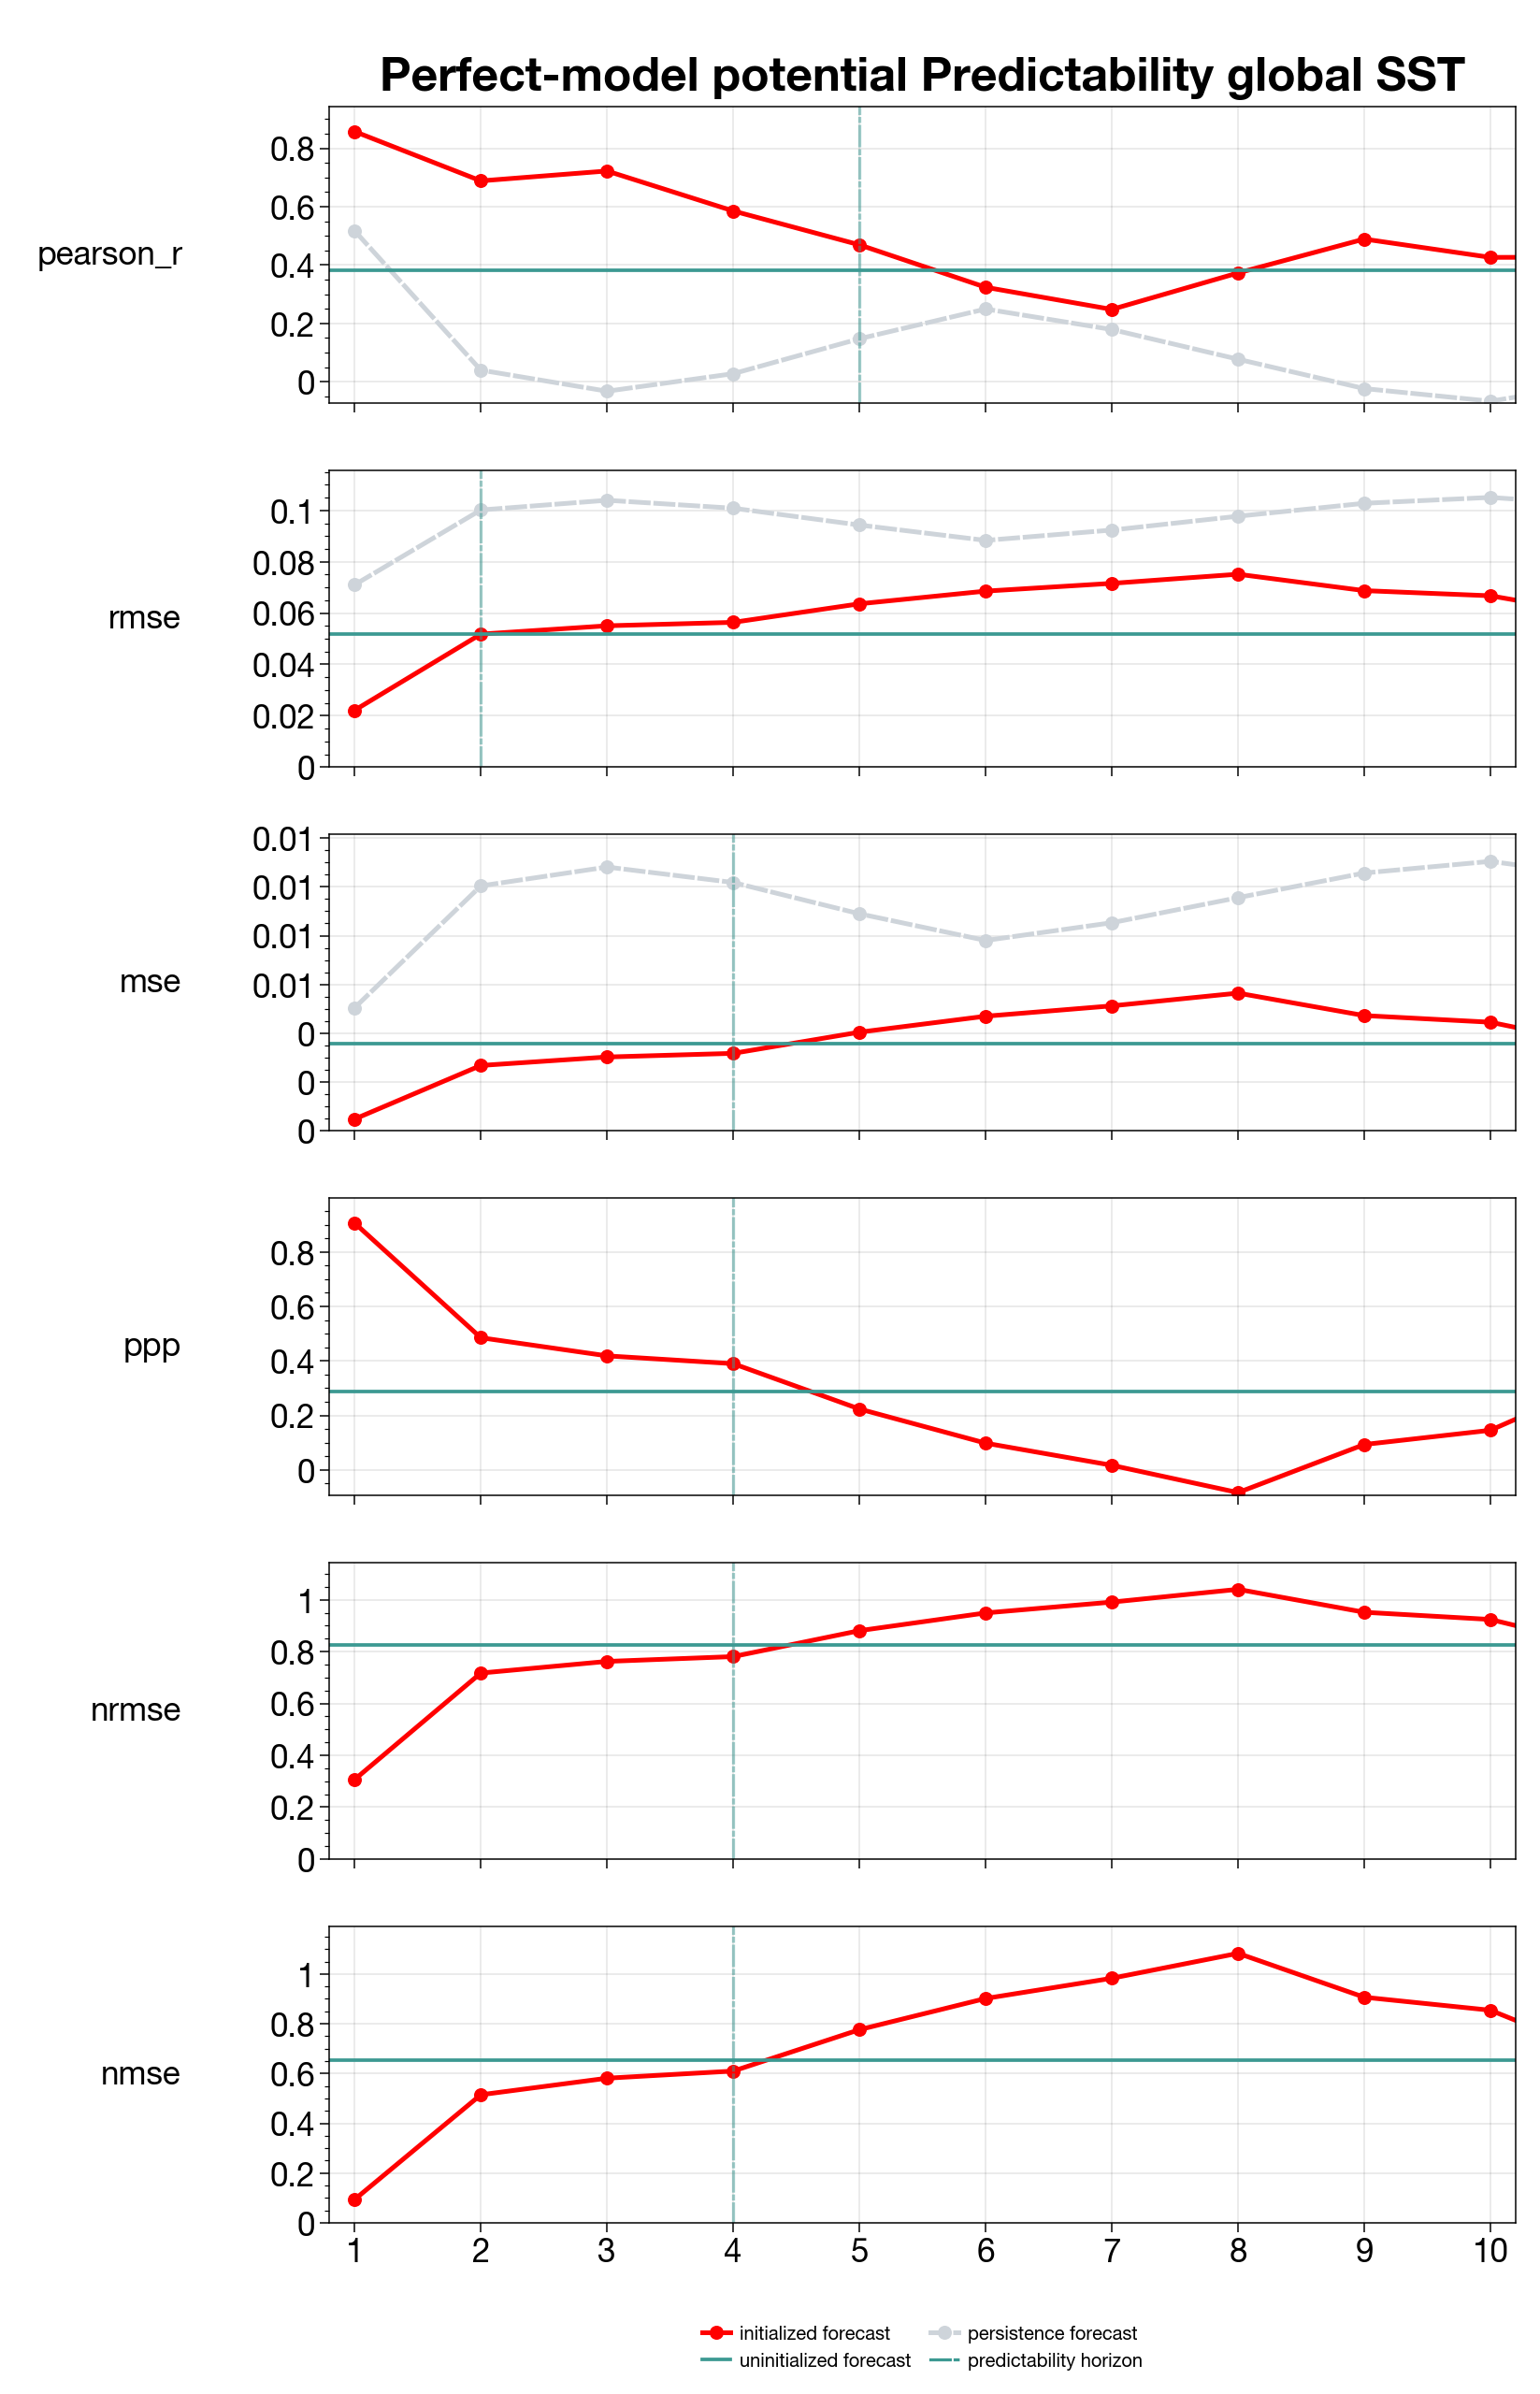

In [10]:
comparison='m2e'
sig=99
bootstrap=100
# Main plot.
metrics = ['pearson_r', 'rmse', 'mse', 'ppp', 'nrmse','nmse']
f, axs = plot.subplots(nrows=len(metrics), ncols=1, axwidth=8, aspect=4, bottomlegend=True,
                       hspace=0.4, left=1)


for ax, metric in zip(axs, metrics):
    ip = compute_perfect_model(ds_, control_, metric=metric, comparison=comparison)
    limit, sigl = _get_limit_sig(metric=metric, sig=sig)
    up = bootstrap_perfect_model(ds_, control_, metric=metric, comparison=comparison, sig=sigl).values
    if metric in ['rmse', 'mse', 'pearson_r']:
        persist = compute_persistence(control_, dim='time', nlags=ds_.time.size, metric=metric)
        persist['time'] = persist['lead time']
        p = _plot_skill(ax, persist, color='gray4', linestyle='--', label='persistence forecast')
    i = _plot_skill(ax, ip, color='r', label='initialized forecast')
    u = ax.axhline(y=up, color='sea', linewidth=1.5, label='uninitialized forecast')
    # predictability horizon
    ph = xr_predictability_horizon(ip, up, limit=limit).values
    php = ax.axvline(x=ph, color='sea', alpha=.5, ls='-.', label='predictability horizon')

    fac = 1.1
    ax.format(ylim=[fac * min(0, up, ip.min('time'),persist.min('lead time')),fac * max(up, ip.max('time'),persist.max('lead time'))])
    persist=persist-persist
    
axs.format(#ylim=[-.5,1.1],
           xlim=[0.8, 10.2], rowlabels=metrics,
           xticks=np.arange(1.,11.),
           xtickminor=False,
           ylabel='', ylabel_kw=dict(fontsize=10),
           rowlabels_kw=dict(weight='normal', fontsize=14),
           collabels=[''],
           collabels_kw=dict(weight='normal', fontsize=14),
           suptitle='Perfect-model potential Predictability global SST')


set_aeshetics(axs)
plt.legend([i[0], p[0], u, php],ncol=2)

## Different comparisons lead to different skill score magnitude by design

# 3-dimensional

## 3-dimensional output
Data is stored on curvilinear grid: lon(y, x), lat(y, x)

In [11]:
ds3d = open_dataset('MPI-DP-3D')
control3d = open_dataset('MPI-control-3D')

## Choose predictability metric and comparison

In [12]:
metric='pearson_r'
comparison='m2e'
sig=99
bootstrap=10
limit, sigl = _get_limit_sig(metric=metric, sig=sig)

## Skill for Lead Year

In [13]:
skill3d = compute_perfect_model(ds3d[varname], control3d[varname], metric=metric, comparison=comparison)

/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


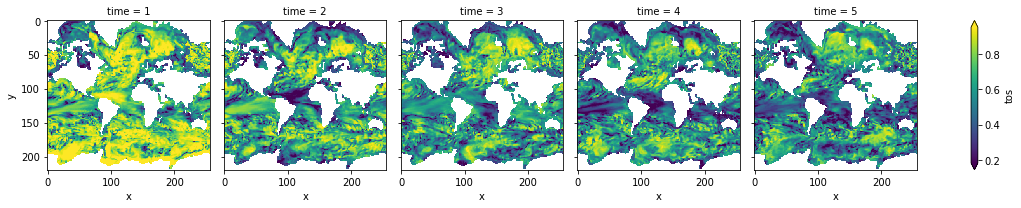

In [15]:
skill3d.plot(robust=True,yincrease=False, col='time')

## Bootstrapped threshold and Predictability Horizon map

In [16]:
threshold3d = bootstrap_perfect_model(ds3d[varname], control3d[varname], metric=metric, comparison=comparison, 
                     sig=sigl, bootstrap=bootstrap)
# threshold3d.plot(robust=True,yincrease=False)

/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [17]:
if limit == 'upper':
    masked3d = skill3d.where(skill3d > threshold3d)
elif limit == 'lower':
    masked3d = skill3d.where(skill3d < threshold3d)

#masked3d.plot(yincrease=False, col='time')
#plt.suptitle('Skill score if above threshold')

Text(0.5, 1.0, 'Predictability Horizon tos')

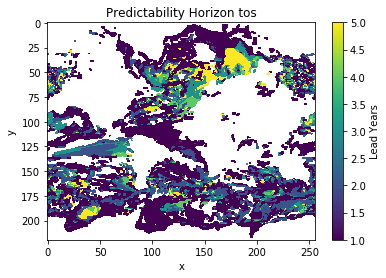

In [18]:
ph3d = xr_predictability_horizon(masked3d, threshold3d, limit=limit)
ph3d.name = 'Lead Years'

ph3d.where(ph3d>0).plot(robust=False,yincrease=False)
plt.title('Predictability Horizon '+varname)

## Persistence
Plot skill where larger than persistence.

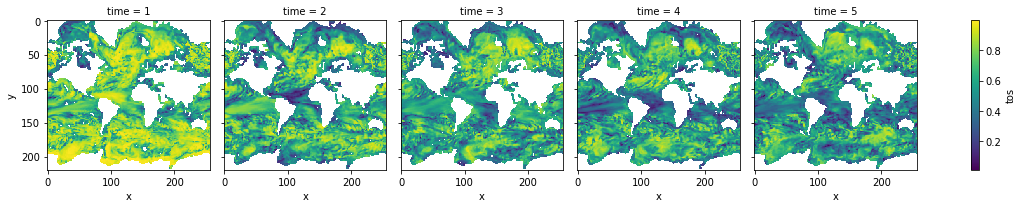

In [19]:
persistence_skill3d = compute_persistence(control3d[varname], nlags=ds3d.time.size,metric=metric, dim='time').rename({'lead time':'time'})
beat_persistence = skill3d.where(skill3d>persistence_skill3d)
beat_persistence.plot(col='time',yincrease=False)

# Slow components of internal variability indicating potential predictability

Set of methods to show regions indicating chances of predictability:
- Decadal Potential Predictability
- Variance-weighted mean period
- Lag1 autocorrelation
- Decorrelation time

## DPP

In [20]:
help(DPP)

Help on function DPP in module climpred.prediction:

DPP(ds, m=10, chunk=True, var_all_e=False)
    Calculate Diagnostic Potential Predictability (DPP) as potentially
    predictable variance fraction (ppvf) in Boer 2004.
    
    Note: Different way of calculating it than in Seferian 2018 or
    Resplandy 2015, but quite similar results.
    
    References
    ----------
    - Boer, G. J. “Long Time-Scale Potential Predictability in an Ensemble of
        Coupled Climate Models.” Climate Dynamics 23, no. 1 (August 1, 2004):
        29–44. https://doi.org/10/csjjbh.
    - Resplandy, L., R. Séférian, and L. Bopp. “Natural Variability of CO2 and
        O2 Fluxes: What Can We Learn from Centuries-Long Climate Models
        Simulations?” Journal of Geophysical Research: Oceans 120, no. 1
        (January 2015): 384–404. https://doi.org/10/f63c3h.
    - Séférian, Roland, Sarah Berthet, and Matthieu Chevallier. “Assessing the
        Decadal Predictability of Land and Ocean Carbon Uptake.

### Resplandy 2015, Seferian 2018 method

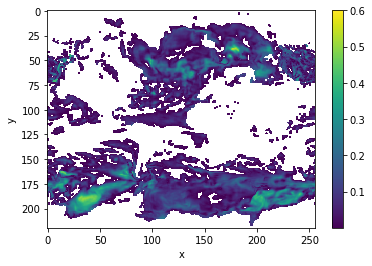

In [21]:
DPP10 = DPP(control3d[varname], m=10, chunk=False)
DPP10.where(DPP10>0).plot(yincrease=False,vmax=.6)

### Original Boer 2004 implementation

/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


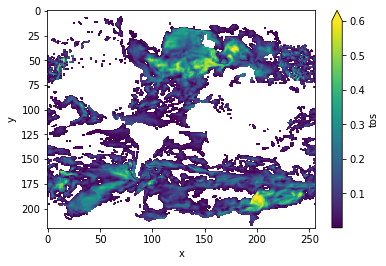

In [22]:
DPP10 = DPP(control3d[varname], m=10, chunk=True)
DPP10.where(DPP10>0).plot(yincrease=False,vmax=.6)

yields similar results

## varweigthed mean period

In [23]:
help(xr_varweighted_mean_period)

Help on function xr_varweighted_mean_period in module climpred.stats:

xr_varweighted_mean_period(ds, time_dim='time')
    Calculate the variance weighted mean period of an xr.DataArray.
    
    Reference
    ---------
    - Branstator, Grant, and Haiyan Teng. “Two Limits of Initial-Value Decadal
      Predictability in a CGCM.” Journal of Climate 23, no. 23 (August 27,
      2010): 6292-6311. https://doi.org/10/bwq92h.



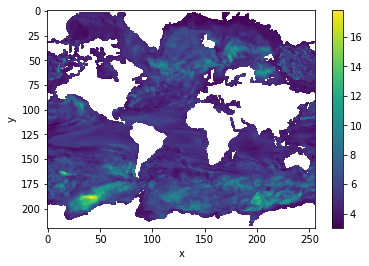

In [24]:
from climpred.stats import xr_varweighted_mean_period as xvmp
varweighted_mean_period = xvmp(control3d[varname],time_dim='time')
varweighted_mean_period.plot(yincrease=False)

## Lag1 autocorrelation

In [25]:
help(xr_autocorr)

Help on function xr_autocorr in module climpred.stats:

xr_autocorr(ds, lag=1, dim='time', return_p=False)
    Calculated lagged correlation of a xr.Dataset.
    
    Parameters
    ----------
    ds : xarray dataset/dataarray
    lag : int (default 1)
        number of time steps to lag correlate.
    dim : str (default 'time')
        name of time dimension/dimension to autocorrelate over
    return_p : boolean (default False)
        if false, return just the correlation coefficient.
        if true, return both the correlation coefficient and p-value.
    
    Returns
    -------
    r : Pearson correlation coefficient
    p : (if return_p True) p-value



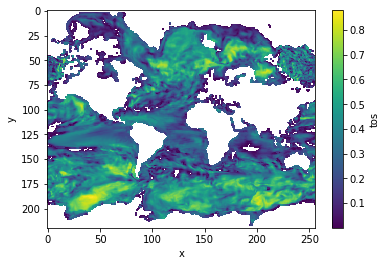

In [26]:
corr_ef = xr_autocorr(control3d[varname],dim='time')
corr_ef.where(corr_ef>0).plot(yincrease=False, robust=False)

## Decorrelation time

In [27]:
help(xr_decorrelation_time)

Help on function xr_decorrelation_time in module climpred.stats:

xr_decorrelation_time(da, r=20, dim='time')
    Calculate decorrelation time of an xr.DataArray.
    
    tau_d = 1 + 2 * sum_{k=1}^(infinity)(alpha_k)**k
    
    Parameters
    ----------
    da : xarray object
    r : int (default 20)
        Number of iterations to run of the above formula
    dim : str (default 'time')
        Time dimension for xarray object
    
    Reference
    ---------
    - Storch, H. v, and Francis W. Zwiers. Statistical Analysis in Climate
    Research. Cambridge ; New York: Cambridge University Press, 1999., p.373



/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


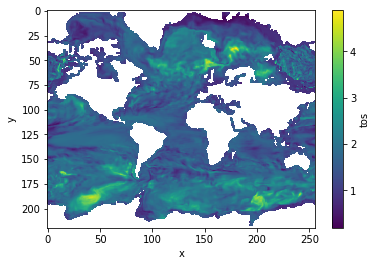

In [28]:
decorr_time = xr_decorrelation_time(control3d[varname])
decorr_time.where(decorr_time>0).plot(yincrease=False, robust=False)